In [47]:
from crud import *
from data import *
import statsmodels.api as sm
import matplotlib.pyplot as plt
from signal_utils import *
from scipy.signal import argrelextrema


In [33]:
mdb = MetadataDB()
tickers = mdb.get_all_tickers()

In [34]:
prices = load_eod_prices()

In [35]:
ticker = "RIG"
benchmark = "OIH"
lookback = 252

In [36]:
ticker_prices = prices[ticker]["close"]
benchmark_prices = prices[benchmark]["close"]

In [37]:
ticker_returns = ticker_prices.pct_change()
benchmark_returns = benchmark_prices.pct_change()

ticker_returns = ticker_returns[1:]
benchmark_returns = benchmark_returns[1:]

## Beta Exploration

In [38]:
# run a regression on returns
def regress_returns(y, x):
    X = sm.add_constant(x)
    model = sm.OLS(y, X)
    results = model.fit()
    return results
results = regress_returns(ticker_returns[-lookback:], benchmark_returns[-lookback:])

In [39]:
print("R2:", results.rsquared.round(2))
print("Const:", results.params.const.round(3))
print("Beta:", results.params.close.round(2))

R2: 0.63
Const: 0.002
Beta: 1.28


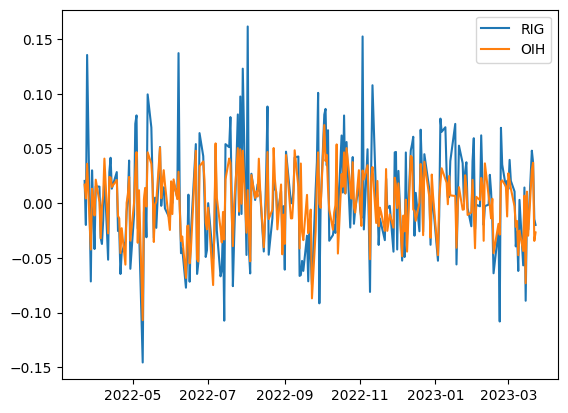

In [40]:
# plot it
plt.plot(ticker_returns[-lookback:], label=ticker)
plt.plot(benchmark_returns[-lookback:], label=benchmark)
plt.legend()

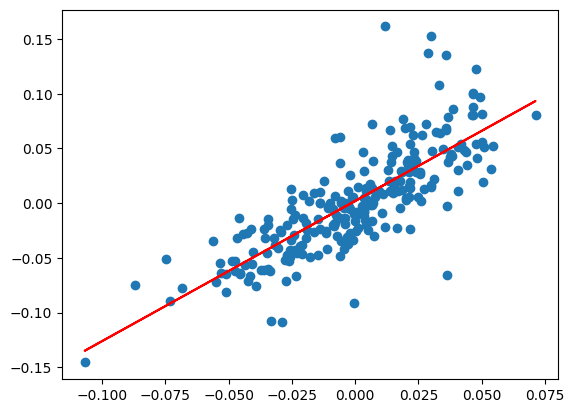

In [41]:
plt.plot(benchmark_returns[-lookback:], results.params[0] + results.params[1] * benchmark_returns[-lookback:], 'r', label='regression line')
plt.scatter(benchmark_returns[-lookback:], ticker_returns[-lookback:], label="scatter")

## Lagged Analysis

In [42]:
# hypothesis is that ticker follows the benchmark
# shift accordingly 

def pairwise_max_corr(ts1, ts2):
    max_shift = 30

    data = []

    for lag in range(1, max_shift+1):
        leader_returns = ts1[-lookback-lag:-lag]
        follower_returns = ts2[-lookback:]

        leader_returns = leader_returns.values
        follower_returns = follower_returns.values

        #cov = follower_returns.cov(leader_returns)
        regression = regress_returns(follower_returns, leader_returns)
        beta = regression.params[1]
        r2 = regression.rsquared

        data.append((lag, 0, beta, r2))

    max_r2 = max(data, key=lambda x: x[3])
    return max_r2


In [27]:
threshold = 0.1
for t1 in tickers:
    for t2 in tickers:
        if t1 == t2:
            continue
        try:
            max_row = pairwise_max_corr(prices[t1]["close"].pct_change()[1:], 
                        prices[t2]["close"].pct_change()[1:])
            if max_row[3] > threshold:
                print(f"Pair {t1} {t2} has correlation {max_row[3]} on lag {max_row[0]}. Beta of {max_row[2]}.")
        except:
            continue

/opt/homebrew/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1752: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Pair CET.TO RVIC has correlation 0.111078551717822 on lag 20. Beta of 0.9003175250329772.
Pair CSV MGNI has correlation 0.1268466350387366 on lag 10. Beta of -0.7179583778378288.
Pair HCITY.MX MGNI has correlation 0.10679619917073391 on lag 16. Beta of 0.7208031134580483.
Pair MSOS CSV has correlation 0.10271403339196061 on lag 15. Beta of -0.24524380727694192.
Pair MSOS HCITY.MX has correlation 0.13749410117988314 on lag 9. Beta of 0.2615014034697214.
Pair RVIC VTNR has correlation 0.11253959693538007 on lag 5. Beta of -0.15141560488670208.
Pair SMR.AU AMC has correlation 0.11888628116921018 on lag 17. Beta of 0.402392895809633.
Pair SMR.AU ARCH has correlation 0.10922415711823774 on lag 2. Beta of 0.33038714846539097.
Pair SPM.MI RVIC has correlation 0.17582676561287913 on lag 29. Beta of 0.6729371723475336.
Pair VRNOF HCITY.MX has correlation 0.12666325209163976 on lag 9. Beta of 0.24523887546224243.
Pair YNDX AMC has correlation 0.1327171306579209 on lag 22. Beta of -0.933324942692

## Basic BT FW Dev / Idio tests

In [58]:
idio_ts = ticker_returns - results.params[0] - results.params[1] * benchmark_returns


/var/folders/_k/rlw58kps0sn5zp0l7hvq_r600000gn/T/ipykernel_6664/492068962.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  buy_df = df[-lookback:][df["buy"] == True]
/var/folders/_k/rlw58kps0sn5zp0l7hvq_r600000gn/T/ipykernel_6664/492068962.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sell_df = df[-lookback:][df["sell"] == True]


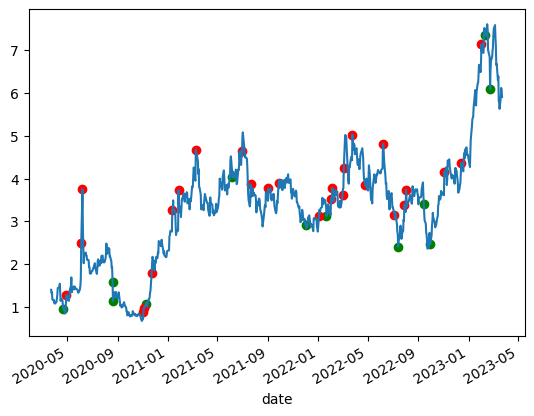

In [59]:
lookback = 252*3

rsi_series = get_rsi(idio_ts, 14)
rsi_zs = get_z_score(rsi_series, 252, last=False)
buy_signal = rsi_zs < -2
sell_signal = rsi_zs > 2

df = pd.DataFrame({"date": rsi_series.index, "price": ticker_prices[1:], "buy": buy_signal, "sell": sell_signal})

# plot it against stock price
df["price"][-lookback:].plot()

buy_df = df[-lookback:][df["buy"] == True]
plt.scatter(buy_df["date"], buy_df["price"], c="green")

sell_df = df[-lookback:][df["sell"] == True]
plt.scatter(sell_df["date"], sell_df["price"], c="red")

In [48]:
# n = 3 # number of points to be checked before and after

# df['min'] = df.iloc[argrelextrema(df["price"].values, np.less_equal,
#                    order=n)[0]]["price"]
# df['max'] = df.iloc[argrelextrema(df["price"].values, np.greater_equal,
#                    order=n)[0]]["price"]

In [60]:
# for each buy/sell signal, find its closet local min/max
n = 5 # is it capturing the best time in 2 week window? 
df["min"] = np.nan
df["max"] = np.nan

df = df.reset_index(drop=True)

for i, row in df.iterrows():
    if row["buy"] == True:
        df.loc[i, "min"] = df.iloc[i-n:i+n]["price"].min()
    if row["sell"] == True:
        df.loc[i, "max"] = df.iloc[i-n:i+n]["price"].max()    

/var/folders/_k/rlw58kps0sn5zp0l7hvq_r600000gn/T/ipykernel_6664/1800369121.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  buy_df = df[-lookback:][df["buy"] == True]
/var/folders/_k/rlw58kps0sn5zp0l7hvq_r600000gn/T/ipykernel_6664/1800369121.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sell_df = df[-lookback:][df["sell"] == True]


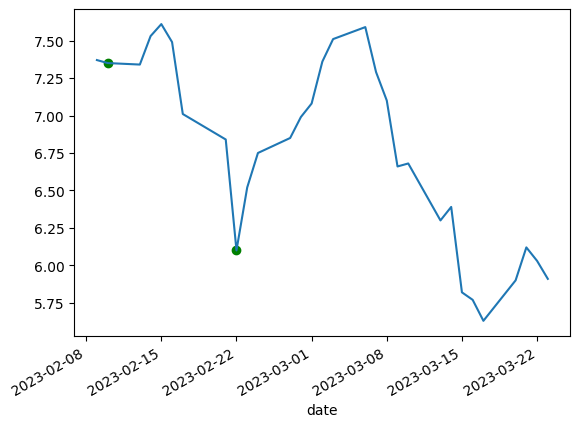

In [74]:
#df = df.set_index("date")
lookback = 30
df["price"][-lookback:].plot()

buy_df = df[-lookback:][df["buy"] == True]
plt.scatter(buy_df.index, buy_df["price"], c="green")

sell_df = df[-lookback:][df["sell"] == True]
plt.scatter(sell_df.index, sell_df["price"], c="red")

#min_df = df[-lookback:][df["min"].notna()]
#plt.scatter(min_df.index, min_df["price"], c="blue")

#max_df = df[-lookback:][df["max"].notna()]
#plt.scatter(max_df.index, max_df["price"], c="blue")


In [82]:
buys = df[df["buy"] == True]
sells = df[df["sell"] == True]

total_error = (buys["price"] / buys["min"] - 1).sum() + (sells["max"] / sells["price"] - 1).sum()
avg_error = total_error / (len(buys) + len(sells))

print("Error:", avg_error)
# avg error, hit rate, number of trades, 

Error: 0.06106309803196201


BT metrics that could be interesting:
- "error": how far from local maxima/minima


## Earth Mover Distance Shenanigans

## TLCC